In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn faker fpdf2 streamlit
!pip install torch --index-url https://download.pytorch.org/whl/cpu
!pip install tensorflow
!pip install transformers
!pip install huggingface_hub
!pip install langchain langchain-community langchain-huggingface
!pip install langchain-experimental

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import torch
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_community.chat_models import ChatHuggingFace
from transformers import AutoModelForCausalLM
from fpdf import FPDF
import os
import streamlit as st

C:\Anaconda3\Lib\site-packages\fpdf\__init__.py:40: UserWarning: You have both PyFPDF & fpdf2 installed. Both packages cannot be installed at the same time as they share the same module namespace. To only keep fpdf2, run: pip uninstall --yes pypdf && pip install --upgrade fpdf2
  warnings.warn(


In [3]:
# Limit TensorFlow GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
faker = Faker()

In [5]:
vendors = {
    'starbucks': 'Food',
    'amazon': 'Shopping',
    'netflix': 'Entertainment',
    'uber': 'Transport',
    'walmart': 'Groceries',
    'spotify': 'Entertainment'
}

In [6]:
def generate_fake_transactions(n=100):
    return pd.DataFrame([{
        'Date': faker.date_between(start_date='-60d', end_date='today'),
        'Vendor': vendor,
        'Amount': round(random.uniform(5.0, 300.0), 2),
        'Category': vendors[vendor]
    } for vendor in random.choices(list(vendors.keys()), k=n)])

In [7]:
USE_FAKE_DATA = True

In [8]:
def load_real_transactions(path):
    df = pd.read_csv(path, usecols=['date', 'description', 'amount'], low_memory=False)
    df.rename(columns={'date': 'Date', 'description': 'Vendor', 'amount': 'Amount'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Vendor'] = df['Vendor'].str.lower().str.strip()
    df = df[df['Amount'] > 0].dropna()
    return df

In [9]:
if USE_FAKE_DATA:
    df = generate_fake_transactions()
    print("Using FAKE data")
else:
    path = r'C:\Users\aniru\OneDrive\Desktop\ML tutorial\AI Financial tracker\financial_transactions.csv'
    df = load_real_transactions(path)
    print("Using REAL data")

Using FAKE data


In [10]:
# Normalize vendor
df['Vendor'] = df['Vendor'].str.lower().str.strip()

In [11]:
# Add features
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Month'] = df['Date'].dt.to_period('M')
df['Weekday'] = df['Date'].dt.day_name()

In [12]:
# Add categories (only if not already present)
if 'Category' not in df.columns or df['Category'].isnull().any():
    def map_category(vendor):
        vendor = str(vendor).lower()
        if 'uber' in vendor:
            return 'Transport'
        elif 'amazon' in vendor:
            return 'Shopping'
        elif 'walmart' in vendor:
            return 'Groceries'
        elif 'starbucks' in vendor or 'dominos' in vendor:
            return 'Food'
        elif 'netflix' in vendor or 'spotify' in vendor:
            return 'Entertainment'
        else:
            return 'Other'
    df['Category'] = df['Vendor'].apply(map_category)

In [13]:
# Drop any junk
df = df[df['Amount'] > 0]  # Filter refunds, zeroes, or fraudulent hopes
df.dropna(subset=['Date', 'Vendor', 'Amount'], inplace=True)

In [14]:
# Standardize vendor names
df['Vendor'] = df['Vendor'].str.lower().str.strip()

In [15]:
# Add derived time columns
df['Month'] = df['Date'].dt.to_period('M')
df['Weekday'] = df['Date'].dt.day_name()

In [16]:
def map_category(vendor):
    vendor = str(vendor).lower()
    if 'uber' in vendor:
        return 'Transport'
    elif 'amazon' in vendor:
        return 'Shopping'
    elif 'walmart' in vendor:
        return 'Groceries'
    elif 'starbucks' in vendor or 'dominos' in vendor:
        return 'Food'
    elif 'netflix' in vendor or 'spotify' in vendor:
        return 'Entertainment'
    else:
        return 'Other'
df['Category'] = df['Vendor'].apply(map_category)

In [17]:
print(df[['Date', 'Vendor', 'Amount', 'Category']].head())

        Date   Vendor  Amount       Category
0 2025-05-02  walmart   25.17      Groceries
1 2025-03-10  walmart  162.11      Groceries
2 2025-04-09  spotify  143.51  Entertainment
3 2025-04-24     uber  146.34      Transport
4 2025-03-31  walmart   60.39      Groceries


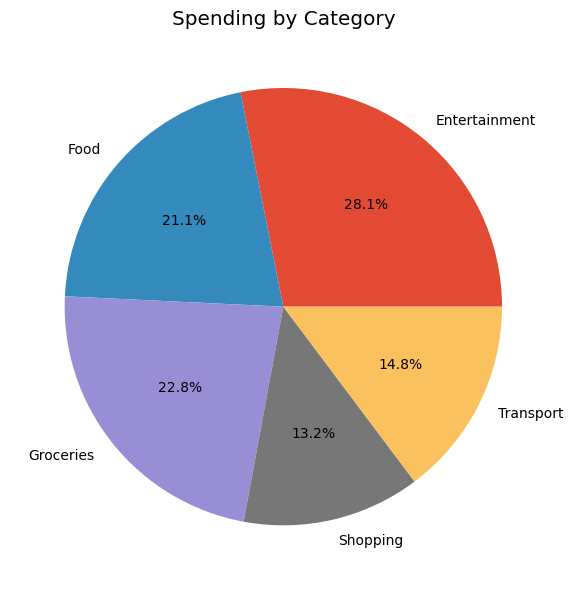

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))
df.groupby('Category')['Amount'].sum().plot.pie(autopct='%1.1f%%')
plt.title('Spending by Category')
plt.ylabel('')
plt.tight_layout()
plt.show()

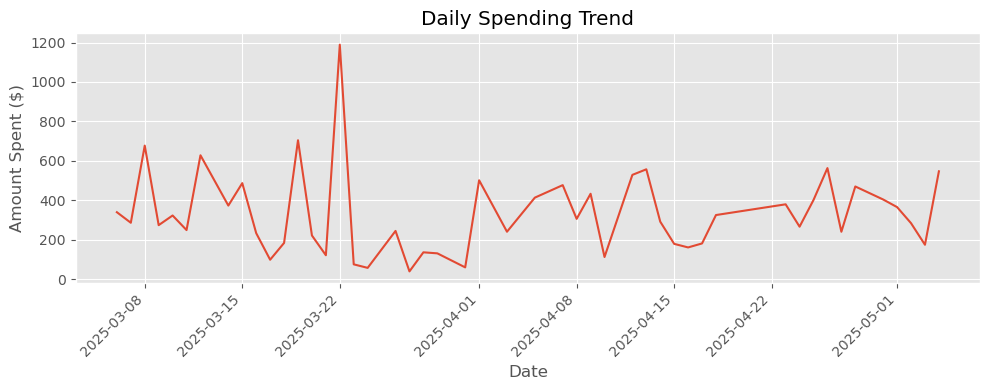

In [19]:
plt.figure(figsize=(10, 4))
daily = df.groupby('Date')['Amount'].sum()
daily.plot()
plt.title('Daily Spending Trend')
plt.ylabel('Amount Spent ($)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

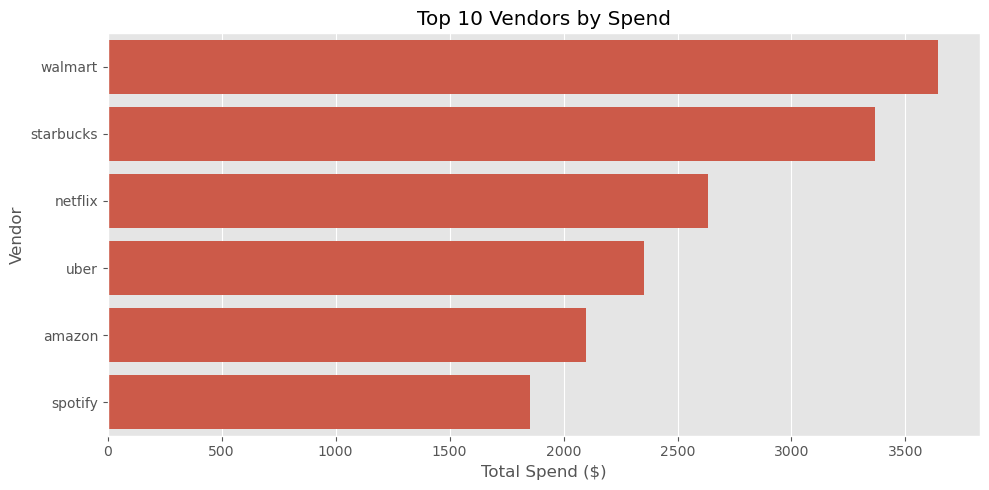

In [20]:
top_vendors = df.groupby('Vendor')['Amount'].sum().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_vendors.values, y=top_vendors.index)
plt.title('Top 10 Vendors by Spend')
plt.xlabel('Total Spend ($)')
plt.tight_layout()
plt.show()

In [21]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_spend = df.groupby('Weekday')['Amount'].sum().reindex(weekday_order)

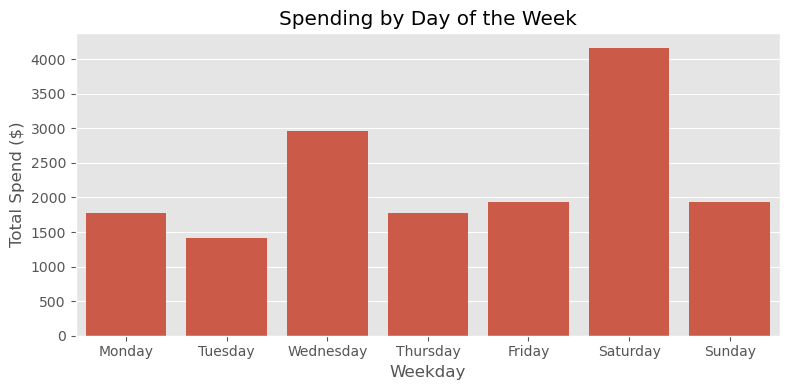

In [22]:
plt.figure(figsize=(8, 4))
sns.barplot(x=weekday_spend.index, y=weekday_spend.values)
plt.title('Spending by Day of the Week')
plt.ylabel('Total Spend ($)')
plt.tight_layout()
plt.show()

In [23]:
vendor_spend = df.groupby('Vendor')['Amount'].sum().nlargest(10).reset_index()

In [24]:
X = vendor_spend[['Amount']]

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
vendor_spend['Cluster'] = kmeans.fit_predict(X)

C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


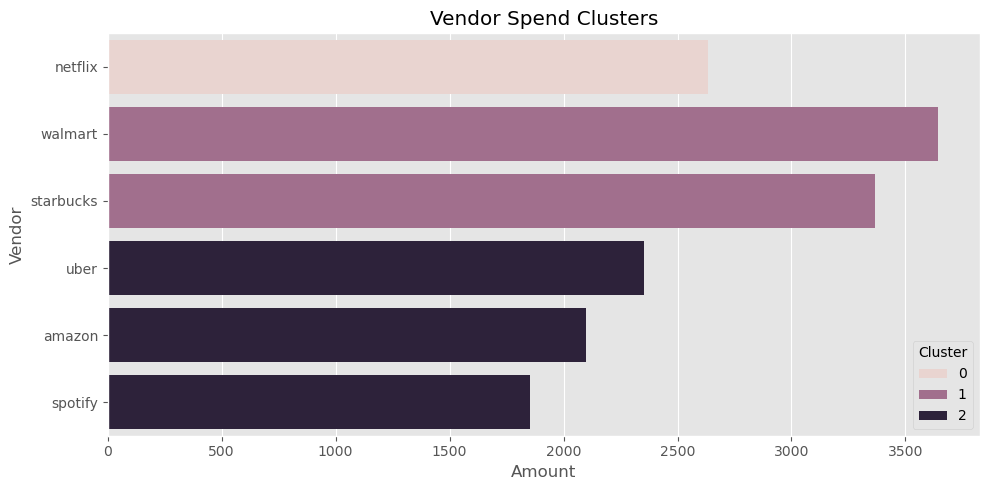

In [26]:
plt.figure(figsize=(10, 5))
sns.barplot(data=vendor_spend.sort_values('Cluster'), x='Amount', y='Vendor', hue='Cluster')
plt.title('Vendor Spend Clusters')
plt.tight_layout()
plt.show()

In [27]:
daily_totals = df.groupby(df['Date'].dt.day)['Amount'].sum().clip(upper=1000)
daily_totals = daily_totals.reset_index()
daily_totals.columns = ['Day', 'Amount']

In [28]:
X = daily_totals[['Day']]
y = daily_totals['Amount']
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [29]:
predicted_day_30 = model.predict(pd.DataFrame({'Day': [30]}))[0]
print(f"Predicted spending on Day 30: ${predicted_day_30:.2f}")

Predicted spending on Day 30: $384.34


In [30]:
spending_summary = "\n".join([
    f"{category}: ${amount:.2f}"
    for category, amount in df.groupby('Category')['Amount'].sum().items()
])

In [31]:
template = PromptTemplate(
    input_variables=["summary"],
    template=(
        "You are a financial assistant. Based on the user's spending summary below, "
        "suggest 3 specific and realistic ways to save money:\n\n{summary}"
    )
)
prompt = template.format(summary=spending_summary)

In [32]:
# Use flan-t5-small (lightweight and CPU-friendly)
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [33]:
# Create HuggingFace pipeline
hf_pipeline = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=100,
    temperature=0.5
)

Device set to use cpu


In [34]:
# Wrap with LangChain
llm = HuggingFacePipeline(pipeline=hf_pipeline)

C:\Users\aniru\AppData\Local\Temp\ipykernel_10224\1411109893.py:2: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=hf_pipeline)


In [35]:
advice = llm(prompt)
print("RoboBudget says:\n")
print(advice)

C:\Users\aniru\AppData\Local\Temp\ipykernel_10224\2134466579.py:1: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  advice = llm(prompt)
C:\Anaconda3\Lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


RoboBudget says:

Money saved by buying a car, a car, or a car.


In [36]:
def export_to_csv(df, advice_text, forecast_amount, path="export/"):
    os.makedirs(path, exist_ok=True)
    now = datetime.now().strftime("%Y-%m-%d_%H-%M")
    df.to_csv(f"{path}transactions_{now}.csv", index=False)
    with open(f"{path}ai_advice_{now}.txt", "w") as f:
        f.write(f"Predicted Spend on Day 30: ${forecast_amount:.2f}\n\n")
        f.write("RoboBudget Advice:\n")
        f.write(advice_text.strip())
    print(f"✅ Exported CSV and Advice to {path}")

In [37]:
def export_to_pdf(df, advice_text, forecast_amount, path="export/"):
    os.makedirs(path, exist_ok=True)
    now = datetime.now().strftime("%Y-%m-%d_%H-%M")
    filename = f"{path}report_{now}.pdf"
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="RoboBudget Summary Report", ln=True, align='C')
    pdf.ln(10)
    pdf.cell(200, 10, txt=f"Generated: {now}", ln=True)
    pdf.ln(10)
    pdf.multi_cell(0, 10, f"Predicted Spend on Day 30: ${forecast_amount:.2f}")
    pdf.ln(5)
    pdf.multi_cell(0, 10, "RoboBudget Advice:\n" + advice_text.strip())
    pdf.ln(10)
    pdf.multi_cell(0, 10, "Spending by Category:\n")
    cat_summary = df.groupby('Category')['Amount'].sum()
    for cat, amt in cat_summary.items():
        pdf.cell(200, 10, txt=f"{cat}: ${amt:.2f}", ln=True)
    pdf.output(filename)
    print(f"PDF exported to {filename}")

In [38]:
export_to_csv(df, str(advice), predicted_day_30)
export_to_pdf(df, str(advice), predicted_day_30)

✅ Exported CSV and Advice to export/
PDF exported to export/report_2025-05-05_15-59.pdf


C:\Users\aniru\AppData\Local\Temp\ipykernel_10224\599672484.py:7: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=12)
C:\Users\aniru\AppData\Local\Temp\ipykernel_10224\599672484.py:8: DeprecationWarning: The parameter "txt" has been renamed to "text" in 2.7.6
  pdf.cell(200, 10, txt="RoboBudget Summary Report", ln=True, align='C')
C:\Users\aniru\AppData\Local\Temp\ipykernel_10224\599672484.py:8: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(200, 10, txt="RoboBudget Summary Report", ln=True, align='C')
C:\Users\aniru\AppData\Local\Temp\ipykernel_10224\599672484.py:10: DeprecationWarning: The parameter "txt" has been renamed to "text" in 2.7.6
  pdf.cell(200, 10, txt=f"Generated: {now}", ln=True)
C:\Users\aniru\AppData\Local\Temp\ipykernel_10224\599672484.py:10: DeprecationWarning: The param

In [39]:
!pip install langchain langchain-community langchain-experimental langchain-huggingface

In [40]:
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType

In [41]:
agent = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True,
    allow_dangerous_code=True  # optional: allows eval-type responses
)

C:\Anaconda3\Lib\site-packages\langchain_experimental\agents\agent_toolkits\pandas\base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(


In [42]:
def fallback_query(df, question):
    question = question.lower()
    if "groceries" in question and "last month" in question:
        last_month = pd.Timestamp.now().to_period("M") - 1
        return df[(df['Category'] == 'Groceries') & (df['Month'] == last_month)]['Amount'].sum()
    elif "top vendor" in question:
        return df.groupby('Vendor')['Amount'].sum().idxmax()
    else:
        return "I don't know how to answer that yet, human."
print(fallback_query(df, "How much did I spend on groceries last month?"))

1529.44


In [43]:
recurring = (
    df.groupby(['Vendor', 'Amount'])
    .size()
    .reset_index(name='Frequency')
    .sort_values('Frequency', ascending=False)
)

In [44]:
# Only keep things that occur frequently
recurring = recurring[recurring['Frequency'] >= 3]
print("Recurring Expenses:")
print(recurring)

Recurring Expenses:
Empty DataFrame
Columns: [Vendor, Amount, Frequency]
Index: []


In [45]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
qa_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

Device set to use cpu


In [46]:
def ask_dataframe_question(question: str, df: pd.DataFrame) -> str:
    q = question.lower()
    if "groceries" in q and "last month" in q:
        last_month = pd.Timestamp.now().to_period("M") - 1
        total = df[(df['Category'] == 'Groceries') & (df['Month'] == last_month)]['Amount'].sum()
        return f"You spent ${total:.2f} on groceries last month."
    elif "top vendor" in q:
        top_vendor = df.groupby("Vendor")['Amount'].sum().idxmax()
        return f"Your top vendor is {top_vendor}."
    elif "average weekly" in q:
        df['Week'] = df['Date'].dt.to_period('W')
        weekly_avg = df.groupby('Week')['Amount'].sum().mean()
        return f"Your average weekly spending is ${weekly_avg:.2f}."
    else:
        return "Sorry, I don't know how to answer that yet."
def get_pretty_response(fact: str):
    prompt = f"Rephrase this in a friendly and helpful tone:\n\n{fact}"
    output = qa_pipeline(prompt, max_length=100, do_sample=False)[0]["generated_text"]
    return output

In [47]:
fact = ask_dataframe_question("How much did I spend on groceries last month?", df)
friendly_response = get_pretty_response(fact)
print(friendly_response)

You spent $1529.44 on groceries last month.


In [48]:
from sklearn.model_selection import train_test_split

In [49]:
print("Number of 'Other' categories:", (df['Category'] == 'Other').sum())
print("Number of non-'Other' categories:", (df['Category'] != 'Other').sum())

Number of 'Other' categories: 0
Number of non-'Other' categories: 100


In [50]:
print(df['Vendor'].sample(10))

86    starbucks
29      spotify
7       walmart
91         uber
26    starbucks
31      walmart
87      walmart
57    starbucks
17         uber
99    starbucks
Name: Vendor, dtype: object


In [51]:
import re

In [52]:
def map_category(vendor):
    vendor = str(vendor).lower()
    if re.search(r'uber|ola|lyft', vendor): return 'Transport'
    elif re.search(r'amazon|flipkart|ebay', vendor): return 'Shopping'
    elif re.search(r'walmart|target|costco', vendor): return 'Groceries'
    elif re.search(r'starbucks|domino|mcdonald|kfc|pizza', vendor): return 'Food'
    elif re.search(r'netflix|spotify|hulu|prime video', vendor): return 'Entertainment'
    else: return 'Other'
df['Category'] = df['Vendor'].apply(map_category)

In [53]:
print(df['Category'].value_counts())

Category
Entertainment    26
Food             23
Groceries        22
Transport        17
Shopping         12
Name: count, dtype: int64


In [54]:
daily_totals = df.groupby('Date')['Amount'].sum()
mean = daily_totals.mean()
std = daily_totals.std()
df_daily = daily_totals.reset_index()
df_daily['ZScore'] = (df_daily['Amount'] - mean) / std
df_daily['Anomaly'] = df_daily['ZScore'].apply(lambda z: abs(z) > 2)

In [55]:
anomalies = df_daily[df_daily['Anomaly']]
print("Suspicious Spending Days:")
print(anomalies[['Date', 'Amount', 'ZScore']])

Suspicious Spending Days:
         Date   Amount    ZScore
15 2025-03-22  1189.07  4.044222


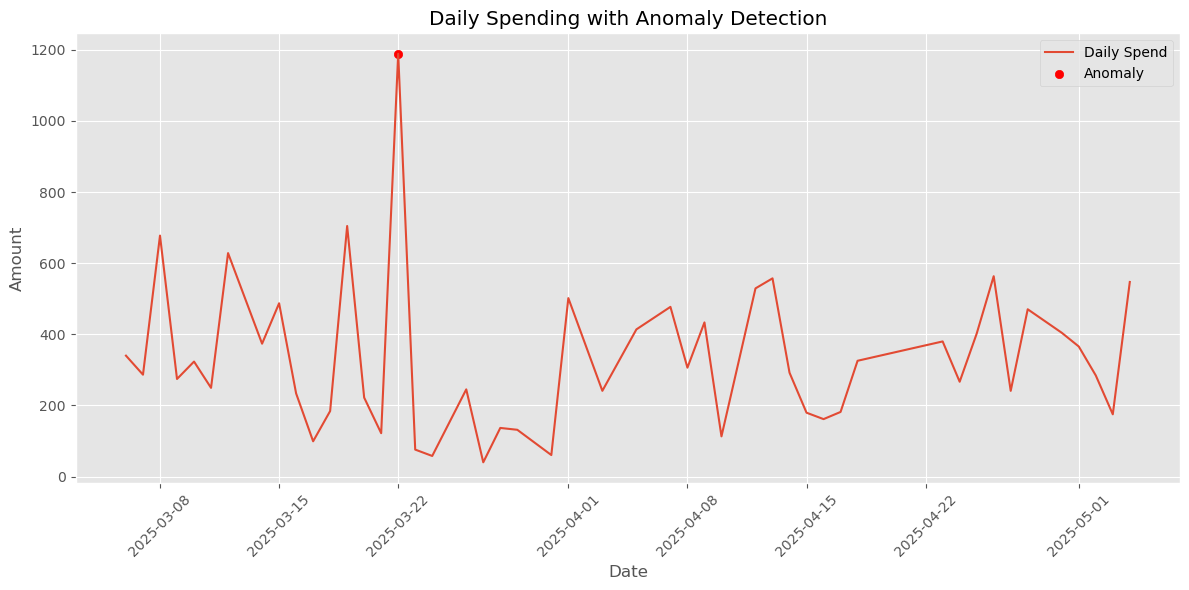

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Date'], df_daily['Amount'], label='Daily Spend')
plt.scatter(anomalies['Date'], anomalies['Amount'], color='red', label='Anomaly')
plt.title('Daily Spending with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
vendor = "Starbucks"  # or any vendor in your fake dataset
vendor_data = df[df['Vendor'] == vendor]
print(f"Vendor: {vendor}")
print("Vendor rows:", len(vendor_data))
print(vendor_data.head())

Vendor: Starbucks
Vendor rows: 0
Empty DataFrame
Columns: [Date, Vendor, Amount, Category, Month, Weekday]
Index: []


In [66]:
vendor = "starbucks"
vendor_data = df[df['Vendor'].str.contains(vendor, case=False, na=False)]

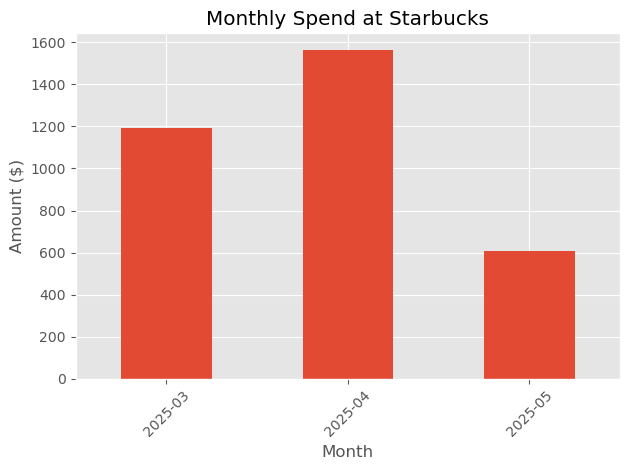

In [68]:
if vendor_data.empty:
    print(f"No data found for vendor: {vendor}")
else:
    monthly = vendor_data.groupby(vendor_data['Date'].dt.to_period('M'))['Amount'].sum()
    monthly.plot(kind='bar', title=f"Monthly Spend at {vendor.title()}")
    plt.ylabel("Amount ($)")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [70]:
vendors = df['Vendor'].unique()
vendor = "walmart"  # or dynamically from user input
if vendor not in vendors:
    print(f"Vendor '{vendor}' not found. Try one of these:")
    print(sorted(vendors[:10]))  # preview only

In [72]:
monthly_budget = 1500  # Or input from user

In [74]:
print(df.sort_values(by='Amount', ascending=False).head(10))

         Date     Vendor  Amount       Category    Month    Weekday
6  2025-03-19    walmart  299.85      Groceries  2025-03  Wednesday
84 2025-04-07    walmart  299.00      Groceries  2025-04     Monday
69 2025-04-18    walmart  295.11      Groceries  2025-04     Friday
36 2025-04-14       uber  291.99      Transport  2025-04     Monday
93 2025-04-09     amazon  289.91       Shopping  2025-04  Wednesday
64 2025-04-12     amazon  285.16       Shopping  2025-04   Saturday
60 2025-04-05    spotify  282.56  Entertainment  2025-04   Saturday
87 2025-04-13    walmart  281.24      Groceries  2025-04     Sunday
22 2025-04-26  starbucks  280.40           Food  2025-04   Saturday
53 2025-04-25    spotify  276.82  Entertainment  2025-04     Friday


In [76]:
print("Max:", df['Amount'].max())
print("Mean:", df['Amount'].mean())
print("Median:", df['Amount'].median())

Max: 299.85
Mean: 159.54149999999998
Median: 164.135


In [78]:
# Force numeric only
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df = df[df['Amount'] > 0]
df = df[df['Amount'] < 10000]  # optional: cap absurd charges

In [80]:
# Ensure 'Amount' is numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

In [82]:
# Drop invalid or missing values
df = df.dropna(subset=['Amount'])
df = df[df['Amount'] > 0]

In [84]:
# Optional: Filter out ultra-high outliers (unless you’re truly that reckless)
df = df[df['Amount'] < 10000]  # You can raise this if you're fancy

In [86]:
# User-defined monthly budget
monthly_budget = 1500

In [88]:
# Sanity filter: drop any rows with ridiculously large amounts
df = df[df['Amount'] < 10000]
# Optional: Cap amounts even more strictly
df = df[df['Amount'] < 5000]  # personal finance, not corporate loans

In [90]:
print(df.sort_values('Amount', ascending=False).head(10))

         Date     Vendor  Amount       Category    Month    Weekday
6  2025-03-19    walmart  299.85      Groceries  2025-03  Wednesday
84 2025-04-07    walmart  299.00      Groceries  2025-04     Monday
69 2025-04-18    walmart  295.11      Groceries  2025-04     Friday
36 2025-04-14       uber  291.99      Transport  2025-04     Monday
93 2025-04-09     amazon  289.91       Shopping  2025-04  Wednesday
64 2025-04-12     amazon  285.16       Shopping  2025-04   Saturday
60 2025-04-05    spotify  282.56  Entertainment  2025-04   Saturday
87 2025-04-13    walmart  281.24      Groceries  2025-04     Sunday
22 2025-04-26  starbucks  280.40           Food  2025-04   Saturday
53 2025-04-25    spotify  276.82  Entertainment  2025-04     Friday


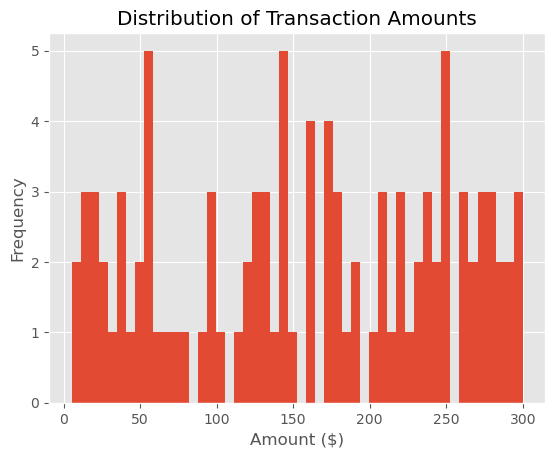

In [92]:
plt.hist(df['Amount'], bins=50)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount ($)")
plt.ylabel("Frequency")
plt.show()

In [94]:
def realistic_amount():
    return round(np.random.lognormal(mean=3.5, sigma=0.5), 2)
def generate_fake_transactions(n=300):
    return pd.DataFrame([{
        'Date': faker.date_between(start_date='-60d', end_date='today'),
        'Vendor': vendor,
        'Amount': realistic_amount(),
        'Category': vendors[vendor]
    } for vendor in random.choices(list(vendors.keys()), k=n)])

In [96]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
predictor = pipeline("text2text-generation", model=model, tokenizer=tokenizer)
def forecast_spend(category, history):
    prompt = f"Given my past monthly {category} spending: {', '.join(map(str, history))}, what will I spend next month?"
    result = predictor(prompt)[0]['generated_text']
    return result

Device set to use cpu


In [100]:
profile_data = df.groupby('Category')['Amount'].sum().reset_index()
X = profile_data[['Amount']]

In [102]:
num_samples = len(profile_data)
if num_samples >= 3:
    k = min(3, num_samples)
    profile_data['Cluster'] = KMeans(n_clusters=k, n_init=10).fit_predict(X)
else:
    print("Not enough categories to create spending clusters.")

C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [104]:
print(df['Category'].value_counts())

Category
Entertainment    26
Food             23
Groceries        22
Transport        17
Shopping         12
Name: count, dtype: int64


In [106]:
card_rewards = {
    'Food': 0.03,
    'Shopping': 0.02,
    'Transport': 0.01,
    'Groceries': 0.015,
    'Entertainment': 0.02
}

df['Reward'] = df.apply(lambda row: row['Amount'] * card_rewards.get(row['Category'], 0), axis=1)
total_rewards = df['Reward'].sum()
print(f"You could've earned ${total_rewards:.2f} in cashback last month.")

You could've earned $311.00 in cashback last month.


In [108]:
top_vendors = df['Vendor'].value_counts(normalize=True).head(5)
print("Top vendor addictions:")
for vendor, percent in top_vendors.items():
    print(f"- {vendor}: {percent*100:.2f}% of your purchases")

Top vendor addictions:
- starbucks: 23.00% of your purchases
- walmart: 22.00% of your purchases
- uber: 17.00% of your purchases
- netflix: 17.00% of your purchases
- amazon: 12.00% of your purchases


In [110]:
alerts = []
# 40% budget in 3 days
last_3_days = df[df['Date'] >= df['Date'].max() - pd.Timedelta(days=3)]
if last_3_days['Amount'].sum() > monthly_budget * 0.4:
    alerts.append("😮 You’ve spent 40% of your budget in 3 days. Breathe.")
# Excessive Entertainment
entertainment_spend = df[df['Category'] == 'Entertainment']['Amount'].sum()
if entertainment_spend > monthly_budget * 0.3:
    alerts.append("📺 Consider cutting back on Netflix. Your wallet is crying.")
print("\nZen Alerts:")
print("\n".join(alerts) if alerts else "You're financially zen... for now.")


Zen Alerts:
😮 You’ve spent 40% of your budget in 3 days. Breathe.
📺 Consider cutting back on Netflix. Your wallet is crying.


In [114]:
monthly_budget = 5000  # or whatever fantasy number you're pretending to stick to
monthly_totals = df.groupby('Category')['Amount'].sum()
total_spent = monthly_totals.sum()
overage = total_spent - monthly_budget
if overage > 0:
    cuts = monthly_totals.sort_values(ascending=False)
    print(f"You're ${overage:.2f} over. Suggested budget trims:")
    for cat, amt in cuts.items():
        cut_amt = min(amt * 0.25, overage)
        print(f"- Reduce '{cat}' by ${cut_amt:.2f}")
        overage -= cut_amt
        if overage <= 0:
            break
else:
    print("You’re within budget. No cuts necessary.")

You're $10954.15 over. Suggested budget trims:
- Reduce 'Entertainment' by $1122.25
- Reduce 'Groceries' by $911.24
- Reduce 'Food' by $841.94
- Reduce 'Transport' by $588.44
- Reduce 'Shopping' by $524.67


In [118]:
from transformers import pipeline
predictor = pipeline("text-generation", model="gpt2")  # or any other model

Device set to use cpu


In [120]:
def ask_budget_bot(prompt):
    full_prompt = f"You are a financial assistant. {prompt}"
    result = predictor(full_prompt, max_new_tokens=60)
    return result[0]['generated_text'][len(full_prompt):].strip()

In [122]:
# Example:
print(ask_budget_bot("Review my entertainment spending and suggest one realistic way to cut back."))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Do I need a financial advisor when I buy and use a new device? Is it necessary? Yes, but not essential. Check the Financial Advisor FAQ to see if your financial advisor has any written suggestions.

Do I have to take money out of my account if I change money?


In [126]:
zero_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
labels = ["Food", "Shopping", "Transport", "Groceries", "Entertainment", "Bills"]
def auto_categorize(vendor):
    result = zero_classifier(vendor, labels)
    return result['labels'][0]
df['AutoCategory'] = df['Vendor'].apply(auto_categorize)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  68%|######8   | 1.11G/1.63G [00:00<?, ?B/s]

C:\Anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aniru\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [128]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
df['Outlier'] = iso.fit_predict(df[['Amount']])
anomalies = df[df['Outlier'] == -1]
print("🧨 Suspicious Transactions:\n", anomalies)

🧨 Suspicious Transactions:
          Date     Vendor  Amount Category    Month Weekday  Reward  \
26 2025-03-23  starbucks    5.26     Food  2025-03  Sunday  0.1578   

     AutoCategory  Outlier  
26  Entertainment       -1  


In [132]:
print(df.columns)

Index(['Date', 'Vendor', 'Amount', 'Category', 'Month', 'Weekday', 'Reward',
       'AutoCategory', 'Outlier'],
      dtype='object')


In [134]:
import numpy as np
notes = [
    "Dinner at fancy place", 
    "Bought groceries", 
    "Online shopping", 
    "Movie night", 
    "Taxi to work", 
    "Subscription fee", 
    "Spontaneous regret spend"
]
df['Notes'] = np.random.choice(notes, size=len(df))

In [136]:
# If you have a 'Notes' column:
from transformers import pipeline
sentiment = pipeline("sentiment-analysis")
df['Sentiment'] = df['Notes'].apply(lambda x: sentiment(x)[0]['label'] if pd.notnull(x) else None)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [138]:
user_goal = "Save $500 in 2 months"

In [140]:
def suggest_goal_cut(df, goal_amount):
    df_grouped = df.groupby('Category')['Amount'].sum().sort_values(ascending=False)
    cut_plan = {}
    remaining = goal_amount
    for cat, amt in df_grouped.items():
        cut = min(amt * 0.3, remaining)
        if cut > 0:
            cut_plan[cat] = cut
            remaining -= cut
        if remaining <= 0:
            break
    return cut_plan

In [142]:
def reallocate_budget(spending, budget):
    surplus = {}
    deficit = {}
    for cat in budget:
        if spending[cat] < budget[cat]:
            surplus[cat] = budget[cat] - spending[cat]
        elif spending[cat] > budget[cat]:
            deficit[cat] = spending[cat] - budget[cat]
    return {"surplus": surplus, "deficit": deficit}

Text(0.5, 1.0, 'Spending Heatmap')

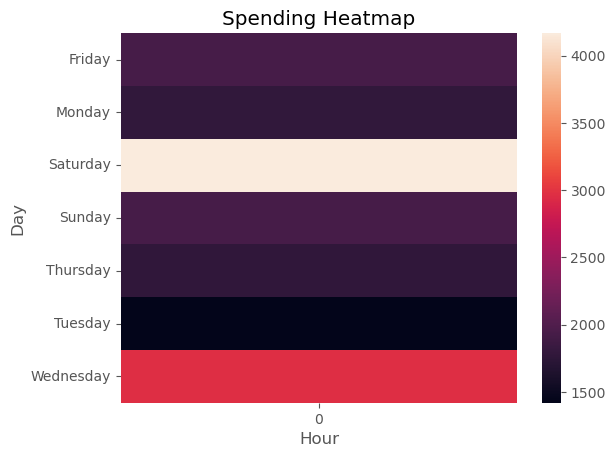

In [144]:
df['Hour'] = df['Date'].dt.hour
df['Day'] = df['Date'].dt.day_name()
heatmap_data = df.pivot_table(index='Day', columns='Hour', values='Amount', aggfunc='sum').fillna(0)
sns.heatmap(heatmap_data)
plt.title("Spending Heatmap")

In [146]:
vendor_freq = df['Vendor'].value_counts(normalize=True)
loyalty = vendor_freq[vendor_freq > 0.05]  # Vendors with >5% of total visits

In [148]:
from transformers import pipeline
zero_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
labels = ["Groceries", "Food", "Bills", "Entertainment", "Transport"]
def auto_categorize(vendor):
    result = zero_classifier(vendor, labels)
    return result['labels'][0]
df['PredictedCategory'] = df['Vendor'].apply(auto_categorize)

Device set to use cpu


Text(0.5, 1.0, 'Monthly Burn Rate')

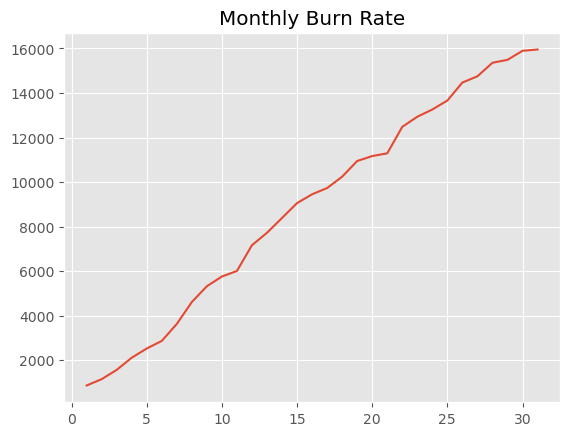

In [150]:
df['DayOfMonth'] = df['Date'].dt.day
burn = df.groupby('DayOfMonth')['Amount'].sum().cumsum()
plt.plot(burn)
plt.title("Monthly Burn Rate")

In [152]:
from transformers import pipeline
zero_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
labels = ["Groceries", "Food", "Bills", "Entertainment", "Transport"]
def auto_categorize(vendor):
    result = zero_classifier(vendor, labels)
    return result['labels'][0]
df['PredictedCategory'] = df['Vendor'].apply(auto_categorize)

Device set to use cpu


Text(0.5, 1.0, 'Monthly Burn Rate')

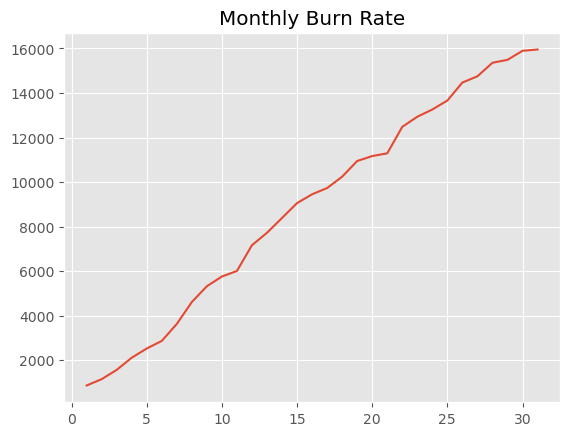

In [154]:
df['DayOfMonth'] = df['Date'].dt.day
burn = df.groupby('DayOfMonth')['Amount'].sum().cumsum()
plt.plot(burn)
plt.title("Monthly Burn Rate")

In [156]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.01)
df['Anomaly'] = model.fit_predict(df[['Amount']])